In [21]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, f1_score, roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, recall_score, precision_score, accuracy_score, roc_auc_score

In [22]:
import warnings

warnings.filterwarnings('ignore')

### 1. Data Loading

In [23]:
churn_data = pd.read_excel('data/Telecom Churn Rate Dataset.xlsx')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,0,0,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,Yes


### 2. EDA

In [24]:
churn_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
numAdminTickets       int64
numTechTickets        int64
Churn                object
dtype: object

In [25]:
def plot_vs_churn(col_name_1):
    
    # group the data by 'Churn' and 'gender'
    grouped = churn_data.groupby(['Churn', col_name_1]).size()

    # unstack the groupby object and plot it as a bar chart
    grouped.unstack().plot(kind='bar')

    # set the labels for the axes and the title of the plot
    plt.xlabel('Churn')
    plt.ylabel(col_name_1)
    plt.title(f'Churn vs. {col_name_1}')

    # show the plot
    plt.show()


In [26]:
object_cols = list(churn_data.select_dtypes(include='object').columns)
object_cols.remove('customerID')
object_cols.remove('Churn')
object_cols.remove('TotalCharges')

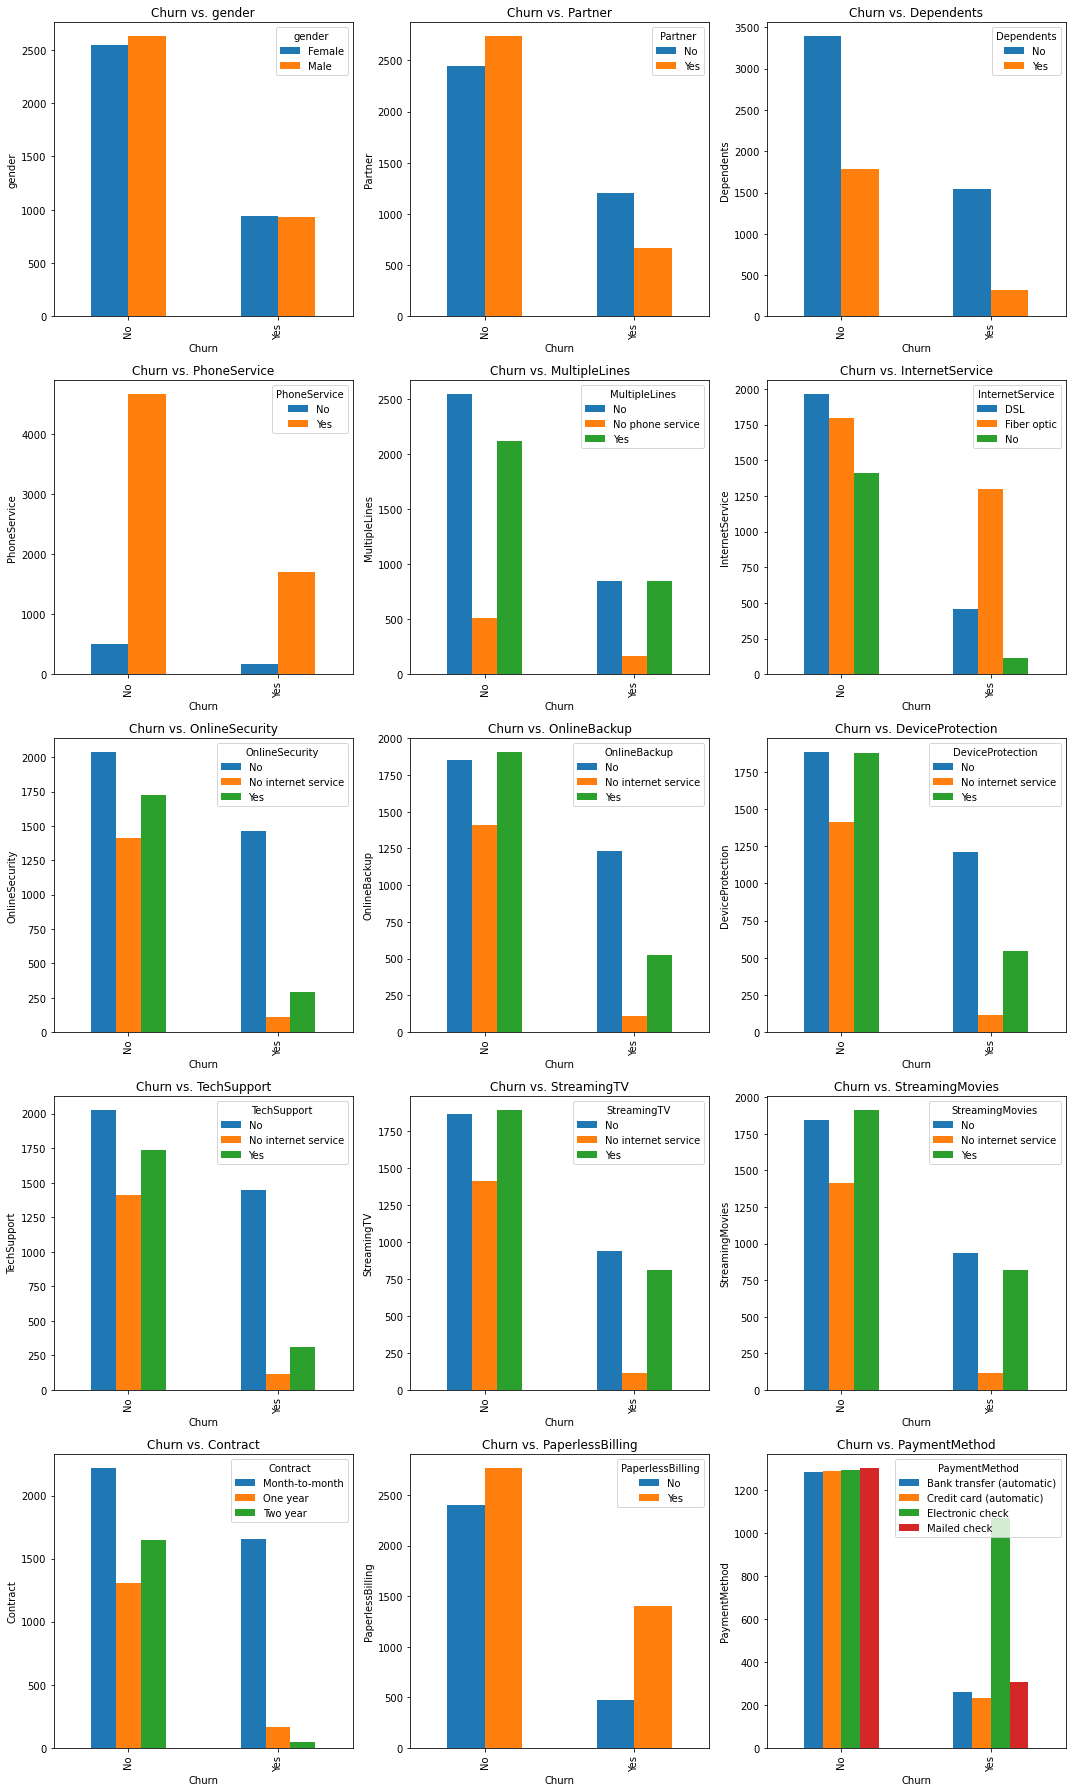

In [27]:
# define the number of columns and rows for the plot grid
cols = 3
rows = math.ceil(len(object_cols) / cols)

# create the plot grid
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# iterate over the columns and plot each chart in a different subplot
for i, col in enumerate(object_cols):
    row_idx = i // cols
    col_idx = i % cols
    ax = axs[row_idx, col_idx]
    grouped = churn_data.groupby(['Churn', col]).size().unstack()
    grouped.plot(kind='bar', ax=ax)
    ax.set_xlabel('Churn')
    ax.set_ylabel(col)
    ax.set_title(f'Churn vs. {col}')

# adjust the layout of the plot and show it
plt.tight_layout()
plt.show()


### 3.Data Pre-Processing

##### 3.1 Categorical

In [28]:
# Converting Binary Variables
churn_data["gender"].replace(["Female", "Male"], [0,1], inplace=True)
col_list = ["Partner","Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in col_list:
    churn_data[col].replace({"Yes":1, "No":0}, inplace=True)

# One-Hot Encoding
# churn_cat = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]

# def categorical_converter(column_name, main_df, cat_df):
#     hot_encoder = OneHotEncoder()
#     encoded_cat = hot_encoder.fit_transform(main_df[[column_name]]).toarray()
#     encoded_df = pd.DataFrame(encoded_cat, columns = hot_encoder.get_feature_names_out())
#     return pd.concat([cat_df,encoded_df], axis = 1)

# cat_df = pd.DataFrame()

# for categorical_column in churn_cat:
#     cat_df = categorical_converter(categorical_column, churn_data, cat_df)

# churn_data = pd.concat([churn_data, cat_df], axis = 1).drop(churn_cat, axis=1)

cols = churn_data.columns.to_list()

object_cols = []
for col in cols:
    if churn_data[col].dtype == object and col not in ['customerID', 'TotalCharges', 'Churn']:
        object_cols.append(col)

churn_data = pd.get_dummies(churn_data, columns = object_cols, drop_first = True)

# Display the first few rows of the encoded data
churn_data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,...,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.5,...,0,0,0,0,0,1,0,0,0,1
2,3668-QPYBK,1,0,0,0,2,1,1,53.85,108.15,...,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,2,1,1,70.70,151.65,...,0,0,0,0,0,0,0,0,1,0


##### 3.2 Numerical

In [9]:
 # Get a list of all columns in churn_data
cols = churn_data.columns.to_list()
object_cols = []

# Loop through all columns in the dataset
for col in cols:
    if churn_data[col].dtype == object and col not in ['customerID', 'TotalCharges', 'Churn']:
        object_cols.append(col)

churn_data = pd.get_dummies(churn_data, columns=object_cols, drop_first=True)
churn_data.drop(churn_data[churn_data['TotalCharges'] == ' '].index, inplace=True)
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float)

numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges', 'numAdminTickets', 'numTechTickets']
scaler = StandardScaler()
churn_data[numeric_columns] = scaler.fit_transform(churn_data[numeric_columns])


In [29]:
churn_data.to_csv('data/Churn_data.csv', index=False)